In [1]:
import time
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from scipy.integrate import solve_ivp#, odeint
from scipy.stats import norm

import pymc3 as pm
import arviz as az
import theano.tensor as tt

In [2]:
SAMPLING_SEED = 987
RANDOM_SEED = 234
np.random.seed(RANDOM_SEED)

In [3]:
def predator_prey(t, y, a, b, c, d):
    return np.array([a*y[0] - b*y[0]*y[1], c*y[0]*y[1] - d*y[1]])

In [4]:
P_0 = 10
Q_0 = 5
a = 3.0
b = 0.7
c = 0.2
d = 1.0

true_parameters = np.array([P_0, Q_0, a, b, c, d])
t_span = [0,12]
t_eval = np.linspace(t_span[0], t_span[1], 1000)

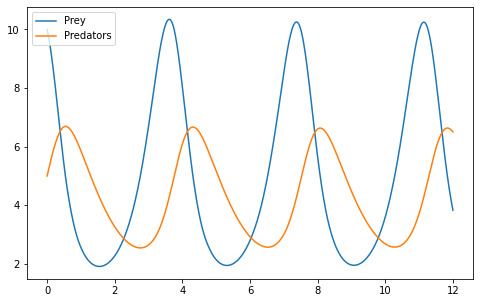

In [5]:
y_true = solve_ivp(predator_prey, t_span, np.array([P_0, Q_0]), args=(a,b,c,d), t_eval=t_eval)

plt.figure(figsize=(8,5))
plt.plot(y_true.t, y_true.y.T, label=['Prey', 'Predators'])
plt.legend(loc=2)
plt.show()

In [6]:
sigma = 1.0
t_end = [4, 8, 12]
n_data = [9, 17, 25]

datapoints = []
data_crisp = []
for t, n in zip(t_end, n_data):
    x = np.linspace(0, t, n)
    datapoints.append(x)
    
    y = solve_ivp(predator_prey, [0, t], np.array([P_0, Q_0]), args=(a,b,c,d), t_eval=x)
    data_crisp.append(y.y)
    #data.append(y.y + np.random.normal(scale=sigma, size=y.y.shape))

data = []
noise = np.random.normal(scale=sigma, size=data_crisp[-1].shape)
for i, d in enumerate(data_crisp):
    d_noise = d + noise[:d.shape[0], :d.shape[1]]
    d_noise[d_noise < 0] = 0
    data.append(d_noise)

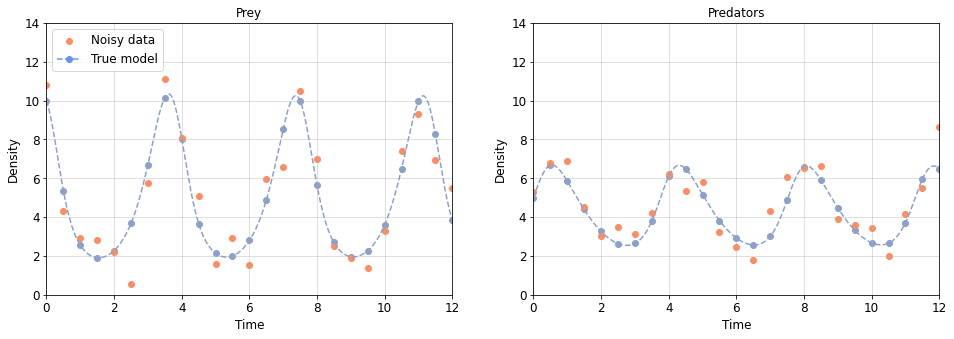

In [7]:
cmap = matplotlib.cm.get_cmap('Set2')

fig, axes = plt.subplots(figsize=(16,5), nrows=1, ncols=2)

axes[0].set_title('Prey', fontsize=12)
axes[0].plot(t_eval, y_true.y[0,:], '--', color=cmap(2))
axes[0].scatter(datapoints[-1], data_crisp[-1][0,:], color=cmap(2))
axes[0].scatter(datapoints[-1], data[-1][0,:], color=cmap(1), label='Noisy data')
axes[0].plot([], [], '--o', color='cornflowerblue', label = 'True model')
axes[0].tick_params(axis='both', labelsize=12)
axes[0].set_xlim(0, 12), axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_ylim(0, 14); axes[0].set_ylabel('Density', fontsize=12)
axes[0].legend(loc=2, fontsize=12)
axes[0].grid(alpha=0.5)

axes[1].set_title('Predators', fontsize=12)
axes[1].plot(t_eval, y_true.y[1,:], '--', color=cmap(2))
axes[1].scatter(datapoints[-1], data_crisp[-1][1,:], color=cmap(2))
axes[1].scatter(datapoints[-1], data[-1][1,:], color=cmap(1), label='Noisy data')
#axes[1].plot([], [], '--o', color='#1f77b4', label = 'True model')
axes[1].tick_params(axis='both', labelsize=12)
axes[1].set_xlim(0, 12), axes[1].set_xlabel('Time', fontsize=12)
axes[1].set_ylim(0, 14); axes[1].set_ylabel('Density', fontsize=12)
axes[1].grid(alpha=0.5)
#axes[1].legend(loc=2, fontsize=12)

plt.savefig('pp_data.pdf', bbox_inches='tight')

In [8]:
class PredatorPreyModel:
    def __init__(self, datapoints):
        self.datapoints = datapoints
        self.n_data = self.datapoints.shape[0]
        self.t_span = [0, self.datapoints[-1]]

    def __call__(self, parameters):
        #print(parameters)
        P_0, Q_0, a, b, c, d = parameters
        y = solve_ivp(predator_prey, self.t_span, np.array([P_0, Q_0]), args=(a,b,c,d), t_eval=self.datapoints) 
        if y.success:
            return y.y
        else:
            return np.zeros((2, self.n_data))

In [9]:
class LogLike(tt.Op):
    
    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, my_model, data, sigma, pymc3_model):

        # add inputs as class attributes
        self.my_model = my_model
        self.data = data
        
        self.sigma = sigma
        
        self.pymc3_model = pymc3_model

    def perform(self, node, inputs, outputs):
        theta = inputs[0]
        
        model_output = self.my_model(theta)
        
        self.pymc3_model.Q.set_value(model_output[1,:].mean())
        logl = -0.5 * np.sum((model_output - self.data)**2)/self.sigma**2
        
        outputs[0][0] = np.array(logl) # output the log-likelihood

In [10]:
ndraws = 10000
ntune = 1000
nchains= 4
nsub = 10

In [12]:
with open('trace_VR.pickle', 'rb') as f:
    trace1 = pickle.load(f)

with open('trace_noVR.pickle', 'rb') as f:
    trace2 = pickle.load(f)

In [13]:
# MLDA without VR
Q_2 = np.array(trace2.get_sampler_stats("Q_2").reshape((1, nchains * ndraws)).tolist())
#Q_2 = trace2.get_sampler_stats("Q_2").reshape((1, nchains * ndraws))

# MLDA with VR
Q_0 = np.concatenate(trace1.get_sampler_stats("Q_0")).reshape((1, nchains * ndraws * nsub * nsub))
Q_1_0 = np.concatenate(trace1.get_sampler_stats("Q_1_0")).reshape((1, nchains * ndraws * nsub))
Q_2_1 = np.concatenate(trace1.get_sampler_stats("Q_2_1")).reshape((1, nchains * ndraws))

# Estimates
Q_mean_standard = Q_2.mean()
Q_mean_vr = Q_0.mean() + Q_1_0.mean() + Q_2_1.mean()

print(f"Q_0 mean = {Q_0.mean()}")
print(f"Q_1_0 mean = {Q_1_0.mean()}")
print(f"Q_2_1 mean = {Q_2_1.mean()}")
print(f"Q_2 mean = {Q_2.mean()}")
print(f"\nVR method:    Mean: {Q_mean_vr}")
print(f"Standard method:    Mean: {Q_mean_standard}")

Q_0 mean = 4.644216974368933
Q_1_0 mean = -0.06284469527344581
Q_2_1 mean = 0.054609725105805876
Q_2 mean = 4.637232566937278

VR method:    Mean: 4.635982004201293
Standard method:    Mean: 4.637232566937278


In [19]:
step = 4000

Q_2_SE = np.zeros(int(nchains * ndraws / step))
Q_0_SE = np.zeros(int(nchains * ndraws / step))
Q_1_0_SE = np.zeros(int(nchains * ndraws / step))
Q_2_1_SE = np.zeros(int(nchains * ndraws / step))
E_standard_SE = np.zeros(int(nchains * ndraws / step))
E_VR_SE = np.zeros(int(nchains * ndraws / step))
k = 0

for i in np.arange(step, nchains * ndraws + 1, step):
    Q_2_SE[k] = Q_2[0, 0:i].var() / az.ess(np.array(Q_2[0, 0:i], np.float64))
    
    Q_0_SE[k] = Q_0[0, 0 : i * nsub * nsub].var() / az.ess(
        np.array(Q_0[0, 0 : i * nsub * nsub], np.float64)
    )
    Q_1_0_SE[k] = Q_1_0[0, 0 : i * nsub].var() / az.ess(
        np.array(Q_1_0[0, 0 : i * nsub], np.float64)
    )
    Q_2_1_SE[k] = Q_2_1[0, 0 : i].var() / az.ess(
        np.array(Q_2_1[0, 0 : i], np.float64)
    )
    
    E_standard_SE[k] = np.sqrt(Q_2_SE[k])
    E_VR_SE[k] = np.sqrt(Q_0_SE[k] + Q_1_0_SE[k] + Q_2_1_SE[k])
    k += 1

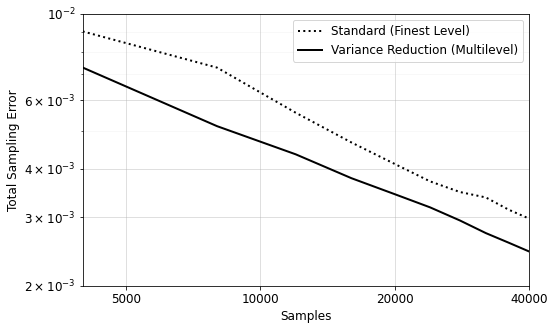

In [28]:
from matplotlib.ticker import ScalarFormatter, LogFormatterSciNotation

fig, ax = plt.subplots(figsize=(8,5))

ax.plot(np.arange(step, nchains * ndraws + 1, step), E_standard_SE, color='k', linewidth=2, linestyle='dotted')
ax.plot(np.arange(step, nchains * ndraws + 1, step), E_VR_SE, color='k', linewidth=2)
ax.set_xscale('log')
ax.set_xticks([5000, 10000, 20000, 40000])
ax.minorticks_off()
ax.get_xaxis().set_major_formatter(ScalarFormatter())
ax.set_xlim(4000, 40000)

ax.set_yscale('log')
ax.set_yticks([2e-3, 3e-3, 4e-3, 6e-3, 1e-2])
ax.get_yaxis().set_major_formatter(LogFormatterSciNotation())
#ax.get_yaxis().set_minor_formatter(LogFormatterSciNotation())

plt.xlabel("Samples", fontsize=12)
plt.ylabel("Total Sampling Error", fontsize=12)
ax.tick_params(axis='both', labelsize=12)

plt.grid(alpha=0.5)
plt.grid(which='minor', alpha=0.1)

ax.legend(["Standard (Finest Level)", "Variance Reduction (Multilevel)"], fontsize=12)
plt.savefig('se.pdf', bbox_inches='tight')